In [1]:
import pandas as pd
from utils.data_utils import load_datasets
from utils.submission_utils import *
import holidays
from sklearn.preprocessing import OneHotEncoder, LabelEncoder 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn import preprocessing

traffic_train = pd.read_csv("../../datasets/training_data.csv", keep_default_na=False, encoding='latin1')
traffic_test = pd.read_csv("../../datasets/test_data.csv", keep_default_na=False, encoding='latin1')
original_test_index = traffic_test.index.copy()

[utils] TRAIN_PATH=../../datasets/training_data.csv
[utils] TEST_PATH=../../datasets/test_data.csv
[utils] OUTPUT_DIR=../../submissions


**Data Treatment**

Drop Columns:
- city_name e Average Precipitation, porque é sempre o mesmo.
- Average Cloudiness e Average Rain, porque tem muitos missing values.
- Average Humidity, porque tem elevada correlação com Average Humidity.????

<Axes: >

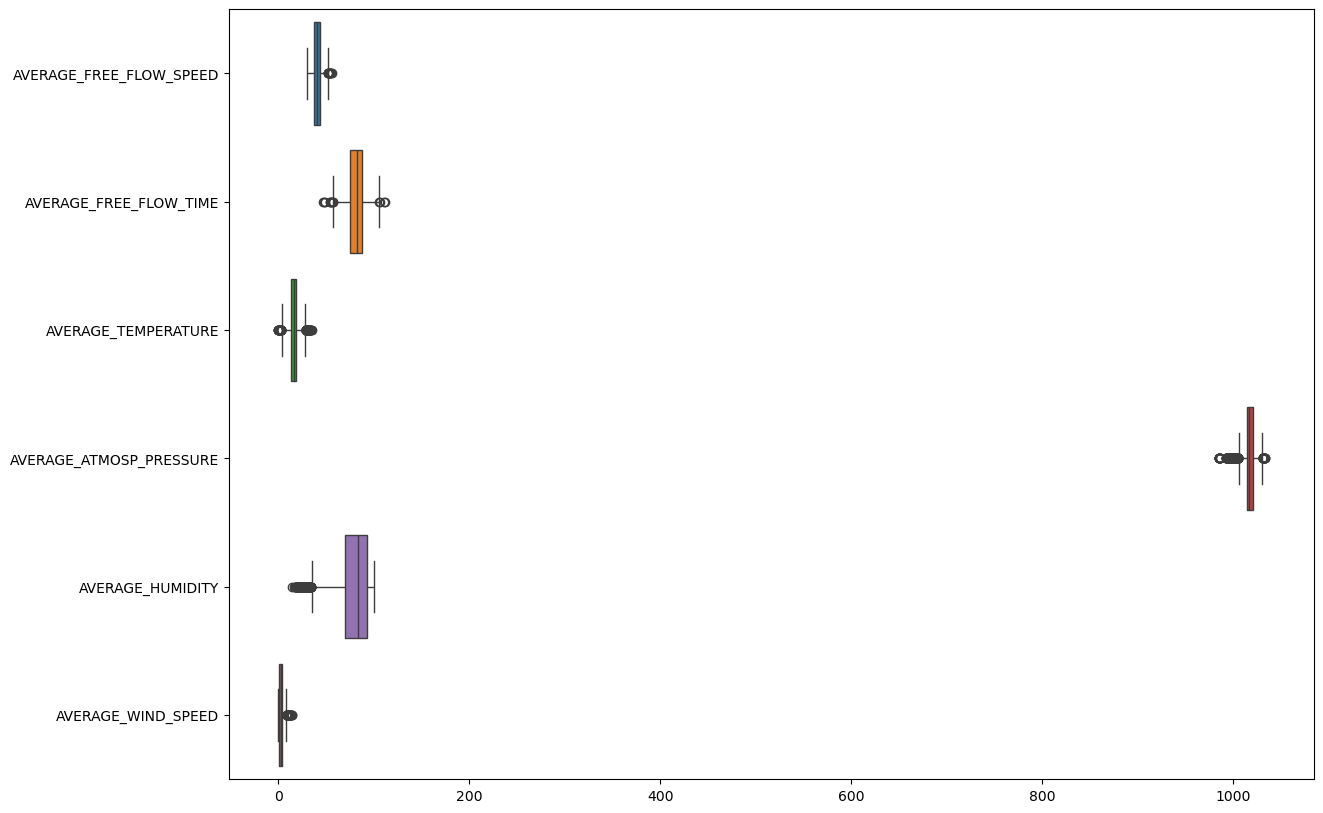

In [104]:
t_copy = traffic_train.copy()
traffic_aux = t_copy.drop(['city_name','record_date','AVERAGE_SPEED_DIFF','LUMINOSITY', 'AVERAGE_CLOUDINESS', 
                            'AVERAGE_RAIN', 'AVERAGE_PRECIPITATION', 'AVERAGE_TIME_DIFF'], axis=1)
plt.subplots(figsize=(14,10))
sns.boxplot(data=traffic_aux, orient="h")

In [2]:
# Drop unnecessary columns 
for df in [traffic_train, traffic_test]:
    df.drop(columns=['city_name'], inplace=True)
    df.drop(columns=['AVERAGE_PRECIPITATION'], inplace=True)
    df.drop(columns=['AVERAGE_RAIN'], inplace=True)
    df.drop(columns=['AVERAGE_CLOUDINESS'], inplace=True)
   #df.drop(columns=['AVERAGE_HUMIDITY'], inplace=True)

Feature Engeneering:
- Partir a data em partes.
- Colocar os dias com uma separação de semana e fim de semana.
- is_weekend para identificar os dias que são fim de semana.
- is_friday para identificar os dias que são sexta-feira.
- is_holiday para identificar os dias que são feriados.
- is_rush_hour para indentificar se é hora de ponta.
- season para identificar a estação do ano correspondente.
- daypart para identificar a parte do dia.

In [3]:
# Date Treatment
for df in [traffic_train, traffic_test]:
    df['record_date'] = pd.to_datetime(df['record_date'])
    #df['date'] = df['record_date'].dt.date
    
    df['Year'] = df['record_date'].dt.year
    df['Month'] = df['record_date'].dt.month
    df['Hour'] = df['record_date'].dt.hour
    
    df['Day'] = df['record_date'].dt.dayofweek
    #df['Day'] = df['record_date'].dt.day_name()
    
    '''
    df['Day'] = df['Day'].replace({
        'Sunday': 1, 'Monday': 0, 'Tuesday': 0, 'Wednesday': 0,
        'Thursday': 0, 'Friday': 0, 'Saturday': 1
    }).astype(int)

    df['hour_sin'] = np.sin(2 * np.pi * df['Hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['Hour'] / 24)

    df['month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['Month'] / 12) '''
    
    #df.drop(columns=['record_date'], inplace=True)

In [4]:
# Feature Engineering
pt_holidays = holidays.Portugal()

for df in [traffic_train, traffic_test]:
    df['is_weekend'] = df['record_date'].dt.weekday.isin([5, 6]).astype(int)
    df['is_friday'] = (df['record_date'].dt.weekday == 4).astype(int)
    df['is_holiday'] = df['record_date'].dt.date.map(lambda d: d in pt_holidays).astype(int)
    df['is_rush_hour'] = ((df['Hour'] >= 7) & (df['Hour'] <= 9)) | ((df['Hour'] >= 17) & (df['Hour'] <= 19)).astype(int)
    df['season'] = pd.cut(df['Month'], bins=[0, 3, 6, 9, 12], labels=['Winter', 'Spring', 'Summer', 'Fall'])
    #df["rush_hour_x_dia"] = df["is_rush_hour"] * df["Day"]
    df.drop(columns=['record_date'], inplace=True)


In [5]:
def daypart(hour):
    if hour > 0 and hour <= 8:
        return "dawn"
    elif hour > 8 and hour <= 16:
        return "working_hour"
    else: return "midnight"

dfs = []
for df in [traffic_train, traffic_test]:
    df_copy = df.copy()
    df_copy['Day_Part'] = df_copy['Hour'].apply(daypart)
    one_hot = pd.get_dummies(df_copy['Day_Part'])
    df_copy = pd.concat([df_copy, one_hot], axis=1)
    df_copy.drop('Day_Part', axis=1, inplace=True)
    dfs.append(df_copy)

traffic_train, traffic_test = dfs[0], dfs[1]

In [27]:
eventos_porto = {
    "jogos_dragao_2018_2019": [
        {"nome": "Porto vs Chaves", "tipo": "Jogo Futebol", "data": "2018-08-11"},
        {"nome": "Porto vs Vitória Guimarães", "tipo": "Jogo Futebol", "data": "2018-08-25"},
        {"nome": "Porto vs Moreirense", "tipo": "Jogo Futebol", "data": "2018-09-02"},
        {"nome": "Porto vs Tondela", "tipo": "Jogo Futebol", "data": "2018-09-28"},
        {"nome": "Porto vs Feirense", "tipo": "Jogo Futebol", "data": "2018-10-28"},
        {"nome": "Porto vs Braga", "tipo": "Jogo Futebol", "data": "2018-11-10"},
        {"nome": "Porto vs Portimonense", "tipo": "Jogo Futebol", "data": "2018-12-07"},
        {"nome": "Porto vs Rio Ave", "tipo": "Jogo Futebol", "data": "2018-12-23"},
        {"nome": "Porto vs Nacional", "tipo": "Jogo Futebol", "data": "2019-01-07"},
        {"nome": "Porto vs B‑SAD", "tipo": "Jogo Futebol", "data": "2019-01-30"},
        {"nome": "Porto vs Benfica", "tipo": "Jogo Futebol", "data": "2018-03-02"},                                                                       
        {"nome": "Porto vs Vitória Setúbal", "tipo": "Jogo Futebol", "data": "2019-02-16"},
        {"nome": "Porto vs Marítimo", "tipo": "Jogo Futebol", "data": "2019-03-16"},
        {"nome": "Porto vs Boavista", "tipo": "Jogo Futebol", "data": "2019-04-05"},
        {"nome": "Porto vs Santa Clara", "tipo": "Jogo Futebol", "data": "2019-04-20"},
        {"nome": "Porto vs Aves", "tipo": "Jogo Futebol", "data": "2019-05-04"},
        {"nome": "Porto vs Sporting CP", "tipo": "Jogo Futebol", "data": "2019-05-18"},
        {"nome": "Porto vs Galatasaray", "tipo": "Champions", "data": "2018-10-03"},
        {"nome": "Porto vs Lokomotiv Moscovo", "tipo": "Champions", "data": "2018-11-06"},
        {"nome": "Porto vs Schalke 04", "tipo": "Champions", "data": "2018-11-28"}
    ]
}

In [28]:
def create_porto_jogos_event(dfs,jogos_dict):
    jogos_date = set()
    for jogo in jogos_dict["jogos_dragao_2018_2019"]:
        dt = datetime.strptime(jogo['data'], '%Y-%m-%d').date()
        jogos_date.add(dt)
    for df in [traffic_train, traffic_test]:
        df['is_fcporto_home_game'] = df['record_date'].isin(jogos_date).astype(int)
        df.drop(columns=['record_date'], inplace=True, errors='ignore')
    return dfs

traffic_train, traffic_test = create_porto_jogos_event(
    [traffic_train, traffic_test],
    eventos_porto 
)

C:\Users\rodme\AppData\Local\Temp\ipykernel_18420\3045795193.py:7: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  df['is_fcporto_home_game'] = df['record_date'].isin(jogos_date).astype(int)
C:\Users\rodme\AppData\Local\Temp\ipykernel_18420\3045795193.py:7: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  df['is_fcporto_home_game'] = df['record_date'].isin(jogos_date).astype(int)


**Categorical Encoding**
- Utilizado nas variáveis categóricas para transformar para numéricas.

In [6]:
# Categorical Encoding
speed_map = {'None': 0, 'Low': 1, 'Medium': 2, 'High': 3, 'Very_High': 4}
traffic_train['AVERAGE_SPEED_DIFF'] = traffic_train['AVERAGE_SPEED_DIFF'].map(speed_map).astype(int)

luminosity_map = {'DARK': 0, 'LOW_LIGHT': 1, 'LIGHT': 2}
traffic_train['LUMINOSITY'] = traffic_train['LUMINOSITY'].replace(luminosity_map).astype(int)
traffic_test['LUMINOSITY'] = traffic_test['LUMINOSITY'].replace(luminosity_map).astype(int)

C:\Users\rodme\AppData\Local\Temp\ipykernel_12972\3862299415.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  traffic_train['LUMINOSITY'] = traffic_train['LUMINOSITY'].replace(luminosity_map).astype(int)
C:\Users\rodme\AppData\Local\Temp\ipykernel_12972\3862299415.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  traffic_test['LUMINOSITY'] = traffic_test['LUMINOSITY'].replace(luminosity_map).astype(int)


In [7]:
rush_hour_map = {'True': 1, 'False': 0}
traffic_train['is_rush_hour'] = traffic_train['is_rush_hour'].replace(rush_hour_map).astype(int)
traffic_test['is_rush_hour'] = traffic_test['is_rush_hour'].replace(rush_hour_map).astype(int)

season_map = {'Winter': 0, 'Spring': 1, 'Summer': 2, 'Fall': 3}
traffic_train['season'] = traffic_train['season'].replace(season_map).astype(int)
traffic_test['season'] = traffic_test['season'].replace(season_map).astype(int)

C:\Users\rodme\AppData\Local\Temp\ipykernel_12972\52076908.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  traffic_train['season'] = traffic_train['season'].replace(season_map).astype(int)
C:\Users\rodme\AppData\Local\Temp\ipykernel_12972\52076908.py:6: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  traffic_train['season'] = traffic_train['season'].replace(season_map).astype(int)
C:\Users\rodme\AppData\Local\Temp\ipykernel_12972\52076908.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version

**Outliers Treatment**

In [8]:
# Outlier Treatment
from scipy.stats.mstats import winsorize

for df in [traffic_train, traffic_test]:
    df['AVERAGE_FREE_FLOW_TIME'] = winsorize(df['AVERAGE_FREE_FLOW_TIME'], limits=[0.01, 0.01])
    df['AVERAGE_FREE_FLOW_SPEED'] = winsorize(df['AVERAGE_FREE_FLOW_SPEED'], limits=[0.05, 0.01])
    df['AVERAGE_TEMPERATURE'] = winsorize(df['AVERAGE_TEMPERATURE'], limits=[0.01, 0.02])
    df['AVERAGE_ATMOSP_PRESSURE'] = winsorize(df['AVERAGE_ATMOSP_PRESSURE'], limits=[0.05, 0.015])
    df['AVERAGE_WIND_SPEED'] = winsorize(df['AVERAGE_WIND_SPEED'], limits=[0.01, 0.03])
    #df['AVERAGE_HUMIDITY'] = winsorize(df['AVERAGE_HUMIDITY'], limits=[0.03, 0.01])

<Axes: >

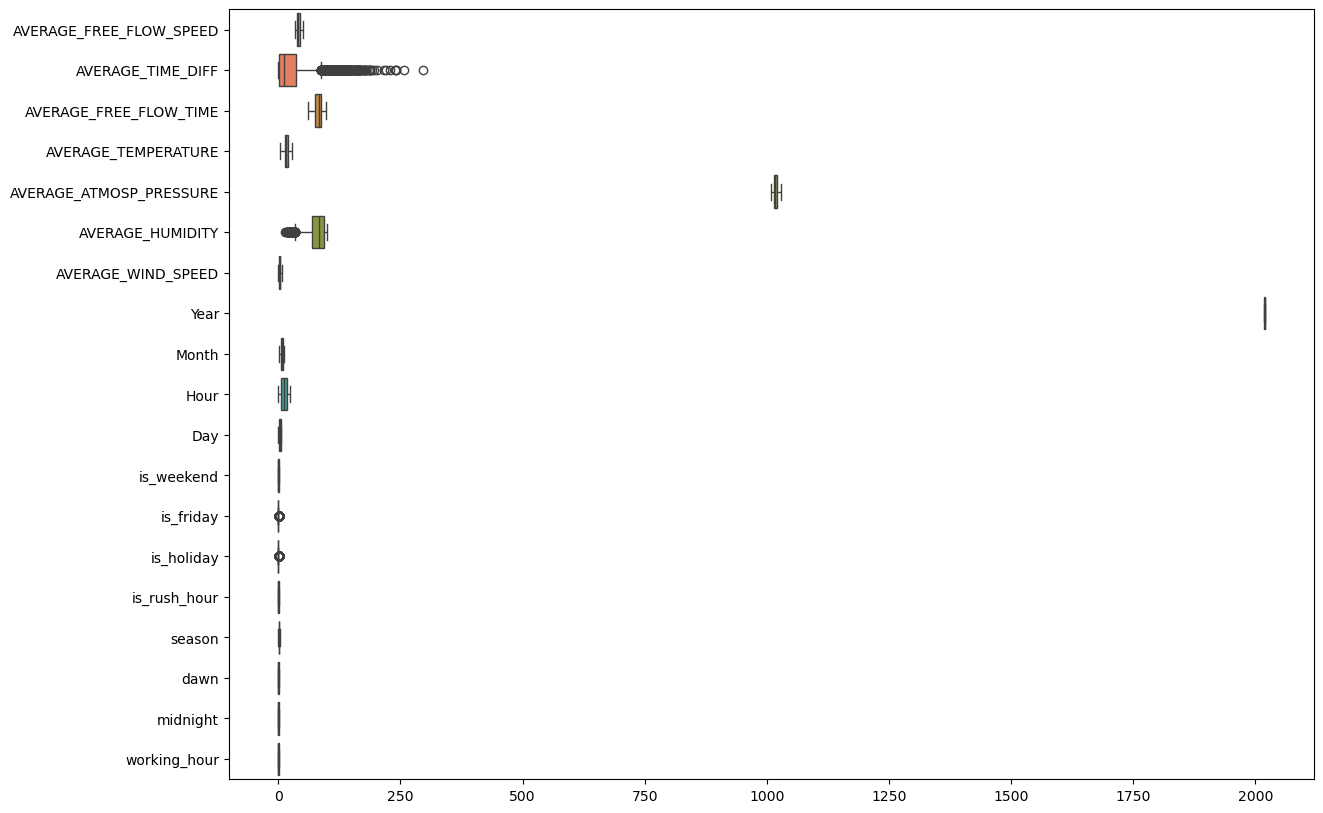

In [34]:
t_copy = traffic_train.copy()
traffic_aux = t_copy.drop(['AVERAGE_SPEED_DIFF','LUMINOSITY'], axis=1)
plt.subplots(figsize=(14,10))
sns.boxplot(data=traffic_aux, orient="h")

In [9]:
def mark_outliers_iqr(s, factor=1.5):
    Q1 = s.quantile(0.25)
    Q3 = s.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - factor * IQR
    upper = Q3 + factor * IQR
    return (~s.between(lower, upper)).astype(int)

traffic_train['time_diff_outlier'] = mark_outliers_iqr(traffic_train['AVERAGE_TIME_DIFF'])
traffic_test['time_diff_outlier'] = mark_outliers_iqr(traffic_test['AVERAGE_TIME_DIFF'])


In [9]:
def is_outlier(s):
    lower_limit = s.mean() - s.std() * 1  
    upper_limit = s.mean() + s.std() * 1
    return ~s.between(lower_limit, upper_limit)

outliers_train = is_outlier(traffic_train['AVERAGE_TIME_DIFF'])

train_com_outliers = traffic_train

**Modeling**

In [10]:
X_train = traffic_train.drop(['AVERAGE_SPEED_DIFF'], axis=1)
y_train = traffic_train['AVERAGE_SPEED_DIFF'].to_frame()

X_test = traffic_test

X_train_final = X_train.to_numpy()
y_train_final = np.ravel(y_train)

X_test_final = X_test.to_numpy()


In [11]:
X_c_outliers = train_com_outliers.drop(['AVERAGE_SPEED_DIFF'], axis=1)
y_c_outliers = train_com_outliers['AVERAGE_SPEED_DIFF'].to_frame()

X_train_final = X_c_outliers.to_numpy()
y_train_final = np.ravel(y_c_outliers)

X_test = traffic_test
X_test_final = X_test.to_numpy()

**Random Forest**

In [ ]:
# Modeling

from sklearn.model_selection import KFold, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import numpy as np

class_weight = {
    0: 0.6184,
    1: 0.9583,
    2: 0.8238,
    3: 1.2780,
    4: 2.8372
}

#smote = SMOTE(random_state=42)
#X_resampled, y_resampled = smote.fit_resample(X_c_outliers, y_c_outliers)

inner_cv = KFold(n_splits=3, shuffle=True, random_state=1)
#inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)

model = RandomForestClassifier(random_state=2025)
#model = RandomForestClassifier(random_state=2025)

param_grid = {
    'n_estimators': [10, 100, 500],
    'max_features': [2, 4, 6],
    'criterion': ['gini', 'entropy']
}

grid_search = GridSearchCV(model, param_grid, cv=inner_cv, scoring='accuracy', n_jobs=1, refit=True)
res = grid_search.fit(X_train_final, y_train_final)
#res = grid_search.fit(X_resampled, np.ravel(y_resampled))

best_model = res.best_estimator_
predictions = best_model.predict(X_test_final)

outer_cv = KFold(n_splits=10, shuffle=True, random_state=1)
#outer_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

scores = cross_val_score(grid_search, X_train_final, y_train_final, cv=outer_cv, scoring='accuracy', n_jobs=-1)
#scores = cross_val_score(grid_search, X_resampled, y_resampled, cv=outer_cv, scoring='accuracy', n_jobs=-1)

print("Accuracy: %.2f%% (+/- %.2f%%)" % (scores.mean() * 100, scores.std() * 100))

Accuracy: 80.37% (+/- 1.74%)


In [13]:
predictions_df = pd.DataFrame({'Speed_Diff': predictions}, index=traffic_test.index)

speed_diff_mapping = {0: 'None', 1: 'Low', 2: 'Medium', 3: 'High', 4: 'Very_High'}
predictions_df['Speed_Diff'] = predictions_df['Speed_Diff'].map(speed_diff_mapping)

create_submission_file(predictions_df,  prediction_col='Speed_Diff', filename='submission_46.csv')

Submissão criada: ../../submissions\submission_46.csv


'../../submissions\\submission_46.csv'

**XGBoost**

In [12]:
# Modeling

from sklearn.model_selection import KFold, GridSearchCV, StratifiedKFold
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
import numpy as np

class_weight = {
    0: 0.6184,
    1: 0.9583,
    2: 0.8238,
    3: 1.2780,
    4: 2.8372
}

smote = SMOTE(random_state=2025)
X_resampled, y_resampled = smote.fit_resample(X_c_outliers, y_c_outliers)

#inner_cv = KFold(n_splits=3, shuffle=True, random_state=1)
inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)

model = XGBClassifier(random_state=2025)


param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'eval_metric': ['logloss', 'mlogloss', 'error']
}

grid_search = GridSearchCV(model, param_grid, cv=inner_cv, scoring='accuracy', n_jobs=1, refit=True)
#res = grid_search.fit(X_train_final, y_train_final)
res = grid_search.fit(X_resampled, np.ravel(y_resampled))

best_model = res.best_estimator_
predictions = best_model.predict(X_test_final)

#outer_cv = KFold(n_splits=10, shuffle=True, random_state=1)
outer_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

#scores = cross_val_score(grid_search, X_train_final, y_train_final, cv=outer_cv, scoring='accuracy', n_jobs=-1)
scores = cross_val_score(grid_search, X_resampled, y_resampled, cv=outer_cv, scoring='accuracy', n_jobs=-1)

print("Accuracy: %.2f%% (+/- %.2f%%)" % (scores.mean() * 100, scores.std() * 100))

Accuracy: 88.15% (+/- 0.74%)


In [13]:
predictions_df = pd.DataFrame({'Speed_Diff': predictions}, index=traffic_test.index)

speed_diff_mapping = {0: 'None', 1: 'Low', 2: 'Medium', 3: 'High', 4: 'Very_High'}
predictions_df['Speed_Diff'] = predictions_df['Speed_Diff'].map(speed_diff_mapping)

create_submission_file(predictions_df,  prediction_col='Speed_Diff', filename='submission_53.csv')

Submissão criada: ../../submissions\submission_53.csv


'../../submissions\\submission_53.csv'

**AdaBoost**


In [17]:
# Modeling

from sklearn.model_selection import KFold, GridSearchCV, StratifiedKFold
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
import numpy as np

class_weight = {
    0: 0.6184,
    1: 0.9583,
    2: 0.8238,
    3: 1.2780,
    4: 2.8372
}

#smote = SMOTE(random_state=42)
#X_resampled, y_resampled = smote.fit_resample(X_c_outliers, y_c_outliers)

inner_cv = KFold(n_splits=3, shuffle=True, random_state=1)
#inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)

model = AdaBoostClassifier(
    random_state=2025,
)

param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1.0],
    'estimator': [DecisionTreeClassifier(max_depth=d) for d in [1, 2, 3]]
}


grid_search = GridSearchCV(model, param_grid, cv=inner_cv, scoring='accuracy', n_jobs=1, refit=True)
res = grid_search.fit(X_train_final, y_train_final)
#res = grid_search.fit(X_resampled, np.ravel(y_resampled))

best_model = res.best_estimator_
predictions = best_model.predict(X_test_final)

outer_cv = KFold(n_splits=10, shuffle=True, random_state=1)
#outer_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

scores = cross_val_score(grid_search, X_train_final, y_train_final, cv=outer_cv, scoring='accuracy', n_jobs=-1)
#scores = cross_val_score(grid_search, X_resampled, y_resampled, cv=outer_cv, scoring='accuracy', n_jobs=-1)

print("Accuracy: %.2f%% (+/- %.2f%%)" % (scores.mean() * 100, scores.std() * 100))

Accuracy: 78.80% (+/- 2.38%)


In [18]:
predictions_df = pd.DataFrame({'Speed_Diff': predictions}, index=traffic_test.index)

speed_diff_mapping = {0: 'None', 1: 'Low', 2: 'Medium', 3: 'High', 4: 'Very_High'}
predictions_df['Speed_Diff'] = predictions_df['Speed_Diff'].map(speed_diff_mapping)

create_submission_file(predictions_df,  prediction_col='Speed_Diff', filename='submission_46.csv')

Submissão criada: ../../submissions\submission_46.csv


'../../submissions\\submission_46.csv'